# 性早熟数据特征可视化分析

本notebook包含特征的可视化分析，包括异常值分析和SHAP解释

## 1. 导入必要的库

In [ ]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LassoCV
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

import os
import joblib

## 2. 设置路径和参数

In [3]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/models", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

## 3. 读取数据

In [4]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

data = pd.concat([normal_data, disease_data], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")

print(f"正常组: {normal_data.shape[0]} 行, 早熟组: {disease_data.shape[0]} 行")
print(f"合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")

正常组: 8227 行, 早熟组: 10457 行
合并后数据: 18684 行 x 48 列


## 4. 划分训练集和验证集

In [5]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

# 数据类型转换
for col in feature_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_validation[col] = pd.to_numeric(X_validation[col], errors="coerce")

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")
print(f"使用 {len(feature_cols)} 个特征")

训练集: 13078 行, 验证集: 5606 行
使用 46 个特征


---
# 特征可视化分析

## 5. 异常值分析（箱线图）

异常值统计 (Top 12):
                 特征  异常值数量  异常值比例(%)  总样本数
    基础血清促黄体生成激素（LH）   2759 15.546290 17747
     基础血清卵泡刺激素（FSH）    716  3.841614 18638
            子宫厚（cm）    695  7.879819  8820
             体重（kg）    548  3.181238 17226
              骨龄(岁)    436  3.170217 13753
                 年龄    431  2.307034 18682
            卵巢体积平均值    398  3.988775  9978
右卵巢体积（长X宽X厚X0.5233）    393  3.969296  9901
左卵巢体积（长X宽X厚X0.5233）    392  4.017628  9757
            子宫宽（cm）    356  4.037197  8818
     BMI （体重Kg÷身高m）    349  2.349535 14854
            子宫长（cm）    313  3.544332  8831


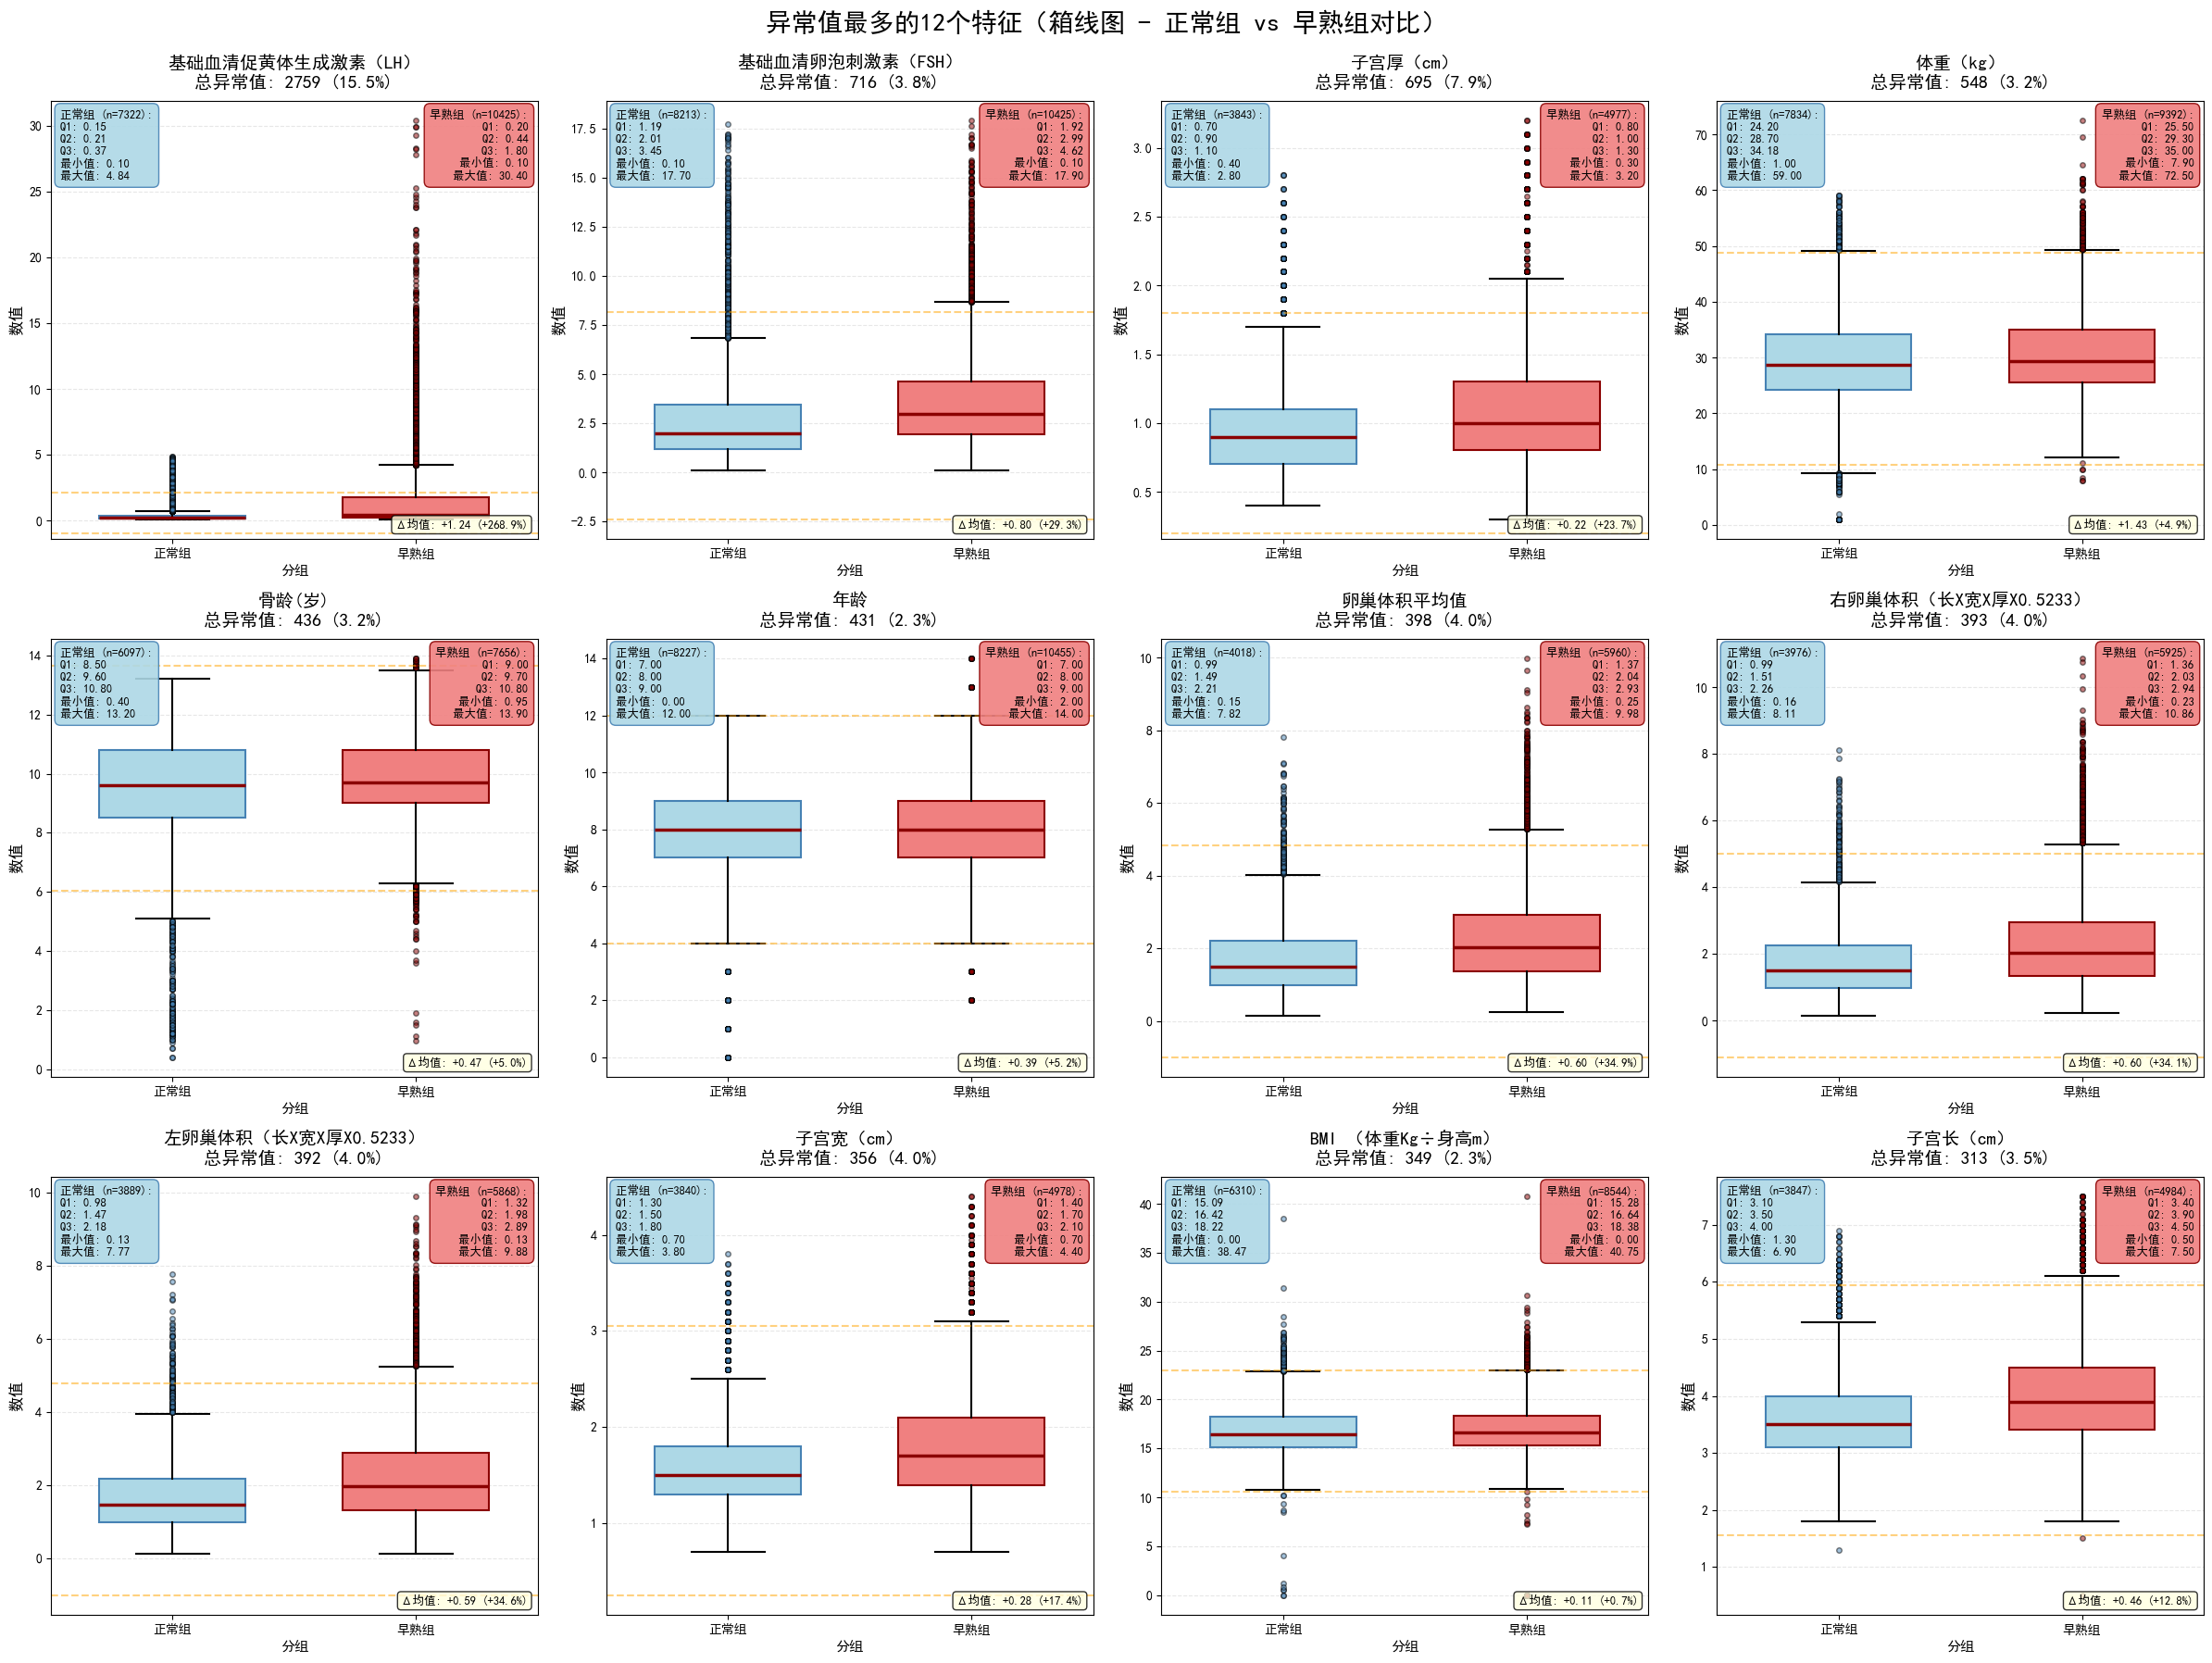

已保存: ./output/特征异常值分析_箱线图_分组对比.pdf
已保存: ./output/特征异常值分析_箱线图_分组对比.png


In [6]:
numeric_data = data[feature_cols].copy()
for col in feature_cols:
    numeric_data[col] = pd.to_numeric(numeric_data[col], errors="coerce")

# 统计每个特征的异常值
outlier_stats = []
for feature in feature_cols:
    values = numeric_data[feature].dropna()

    if len(values) > 0:
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = values[(values < lower_bound) | (values > upper_bound)]
        n_outliers = len(outliers)
        outlier_pct = (n_outliers / len(values)) * 100

        outlier_stats.append(
            {
                "特征": feature,
                "异常值数量": n_outliers,
                "异常值比例(%)": outlier_pct,
                "总样本数": len(values),
            }
        )

outlier_features = pd.DataFrame(outlier_stats).sort_values(
    "异常值数量", ascending=False
)

print("异常值统计 (Top 12):")
print(outlier_features.head(12).to_string(index=False))

if len(outlier_features) > 0:
    top_outlier_features = outlier_features.head(12)["特征"].tolist()
    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    axes = axes.ravel()

    for idx, feature in enumerate(top_outlier_features):
        ax = axes[idx]
        values_all = numeric_data[feature].dropna()

        normal_indices = data[data["group"] == "N"].index
        disease_indices = data[data["group"] == "Y"].index

        values_normal = numeric_data.loc[
            numeric_data.index.intersection(normal_indices), feature
        ].dropna()
        values_disease = numeric_data.loc[
            numeric_data.index.intersection(disease_indices), feature
        ].dropna()

        Q1 = values_all.quantile(0.25)
        Q3 = values_all.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = values_all[(values_all < lower_bound) | (values_all > upper_bound)]
        n_outliers = len(outliers)
        outlier_pct = (n_outliers / len(values_all)) * 100

        # 计算各组的统计量
        q1_normal = values_normal.quantile(0.25)
        q2_normal = values_normal.quantile(0.50)
        q3_normal = values_normal.quantile(0.75)
        min_normal = values_normal.min()
        max_normal = values_normal.max()

        q1_disease = values_disease.quantile(0.25)
        q2_disease = values_disease.quantile(0.50)
        q3_disease = values_disease.quantile(0.75)
        min_disease = values_disease.min()
        max_disease = values_disease.max()

        bp = ax.boxplot(
            [values_normal, values_disease],
            positions=[1, 2],
            widths=0.6,
            patch_artist=True,
            labels=["正常组", "早熟组"],
            boxprops=dict(linewidth=1.5),
            medianprops=dict(color="darkred", linewidth=2.5),
            whiskerprops=dict(color="black", linewidth=1.5),
            capprops=dict(color="black", linewidth=1.5),
            flierprops=dict(marker="o", markersize=4, alpha=0.5),
        )

        bp["boxes"][0].set_facecolor("lightblue")
        bp["boxes"][0].set_edgecolor("steelblue")
        bp["boxes"][1].set_facecolor("lightcoral")
        bp["boxes"][1].set_edgecolor("darkred")

        bp["fliers"][0].set_markerfacecolor("steelblue")
        bp["fliers"][1].set_markerfacecolor("darkred")

        ax.axhline(
            y=lower_bound, color="orange", linestyle="--", linewidth=1.5, alpha=0.5
        )
        ax.axhline(
            y=upper_bound, color="orange", linestyle="--", linewidth=1.5, alpha=0.5
        )

        ax.set_title(
            f"{feature}\n总异常值: {n_outliers} ({outlier_pct:.1f}%)",
            fontsize=14,
            fontweight="bold",
            pad=10,
        )
        ax.set_ylabel("数值", fontsize=12)
        ax.set_xlabel("分组", fontsize=11)
        ax.grid(axis="y", alpha=0.3, linestyle="--")

        # 添加统计量文本框
        stats_normal = (
            f"正常组 (n={len(values_normal)}):\n"
            f"Q1: {q1_normal:.2f}\n"
            f"Q2: {q2_normal:.2f}\n"
            f"Q3: {q3_normal:.2f}\n"
            f"最小值: {min_normal:.2f}\n"
            f"最大值: {max_normal:.2f}"
        )

        stats_disease = (
            f"早熟组 (n={len(values_disease)}):\n"
            f"Q1: {q1_disease:.2f}\n"
            f"Q2: {q2_disease:.2f}\n"
            f"Q3: {q3_disease:.2f}\n"
            f"最小值: {min_disease:.2f}\n"
            f"最大值: {max_disease:.2f}"
        )

        ax.text(
            0.02,
            0.98,
            stats_normal,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            horizontalalignment="left",
            bbox=dict(
                boxstyle="round,pad=0.5",
                facecolor="lightblue",
                edgecolor="steelblue",
                alpha=0.9,
                linewidth=1,
            ),
        )

        ax.text(
            0.98,
            0.98,
            stats_disease,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(
                boxstyle="round,pad=0.5",
                facecolor="lightcoral",
                edgecolor="darkred",
                alpha=0.9,
                linewidth=1,
            ),
        )

        mean_diff = values_disease.mean() - values_normal.mean()
        diff_pct = (
            (mean_diff / values_normal.mean() * 100) if values_normal.mean() != 0 else 0
        )
        diff_text = f"Δ均值: {mean_diff:+.2f} ({diff_pct:+.1f}%)"
        ax.text(
            0.98,
            0.02,
            diff_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8),
            fontweight="bold",
        )

    plt.suptitle(
        "异常值最多的12个特征（箱线图 - 正常组 vs 早熟组对比）",
        fontsize=20,
        fontweight="bold",
        y=0.995,
    )
    plt.tight_layout()
    plt.savefig(
        "./output/特征异常值分析_箱线图_分组对比.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "./output/特征异常值分析_箱线图_分组对比.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print("已保存: ./output/特征异常值分析_箱线图_分组对比.pdf")
    print("已保存: ./output/特征异常值分析_箱线图_分组对比.png")
else:
    print("无异常值，跳过可视化")

## 6. 训练XGBoost模型（用于SHAP分析）

In [7]:
# 训练XGBoost模型用于SHAP分析
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    random_state=RANDOM_SEED,
    tree_method="hist",
    n_jobs=-1,
)
xgb_model.fit(X_train, y_train_binary)

y_pred_proba_xgb = xgb_model.predict_proba(X_validation)[:, 1]
auc_xgb = roc_auc_score(y_validation_binary, y_pred_proba_xgb)

print(f"XGBoost AUC: {auc_xgb:.4f}")

XGBoost AUC: 0.8839


## 7. SHAP特征重要性分析

## 8. LASSO特征选择

LASSO特征选择分析

1. 使用LassoCV进行特征选择...
实际可用特征数: 34 (原始: 46)
  • 最优alpha: 0.000147
  • 交叉验证R²: 0.1865

2. LASSO选择的特征:
  • 原始特征数: 46
  • 实际可用特征数: 34
  • LASSO保留特征数: 31
  • 特征削减率: 8.8%

  选中的31个特征:
     1. 乳腺体厚平均值（cm）                              (|coef|=0.8260)
     2. 左乳腺体厚（cm）                                (|coef|=0.5018)
     3. 右乳腺体厚（cm）                                (|coef|=0.3882)
     4. 卵巢宽平均值（cm）                               (|coef|=0.1950)
     5. 按CHN法测算，左手、腕骨发育成熟度评分                     (|coef|=0.1511)
     6. 卵巢长平均值（cm）                               (|coef|=0.1370)
     7. 基础血清促黄体生成激素（LH）                          (|coef|=0.1033)
     8. 右卵巢长（cm）                                 (|coef|=0.0865)
     9. 左卵巢宽（cm）                                 (|coef|=0.0832)
    10. 左卵巢长（cm）                                 (|coef|=0.0809)
    11. 年龄                                       (|coef|=0.0804)
    12. 骨龄(岁)                                    (|coef|=0.0785)
    13. 右卵巢宽（cm）             

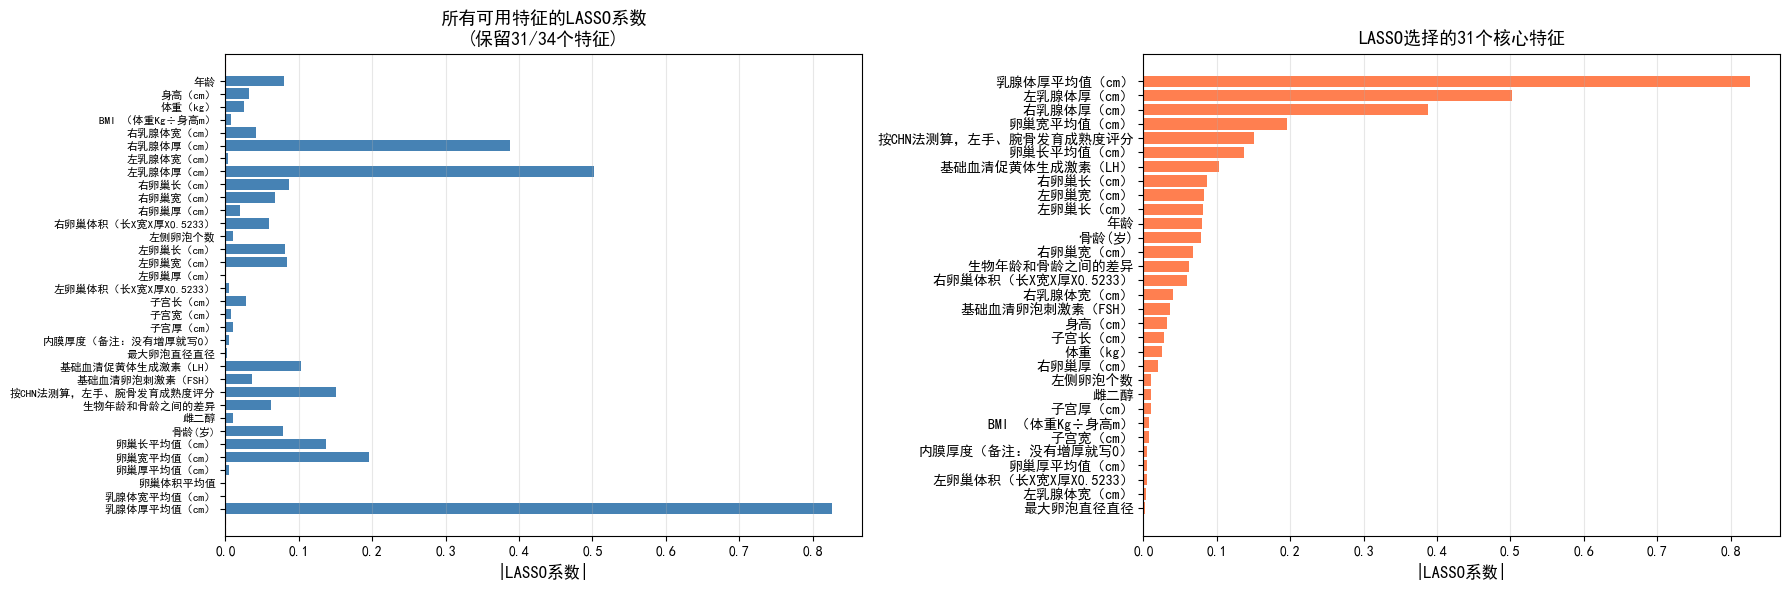


已保存: ./output/LASSO特征选择_系数图.pdf

3. 使用LASSO选择的31个特征重新训练XGBoost...

性能对比:
  • XGBoost (全部46个特征):      AUC = 0.8839
  • XGBoost (LASSO选择31个特征): AUC = 0.8871
  • 性能差异: 0.0032 (+0.4%)

使用31个核心特征可以保持100.4%的性能
  建议：可以使用这些核心特征简化模型，提高可解释性！

LASSO特征选择模型已保存: ./output/models/xgb_lasso_selected.pkl

LASSO特征选择分析完成！


In [8]:
print("=" * 80)
print("LASSO特征选择分析")
print("=" * 80)

# 准备数据（填充缺失值）
imputer_lasso = SimpleImputer(strategy="median")
X_train_lasso = imputer_lasso.fit_transform(X_train)
X_validation_lasso = imputer_lasso.transform(X_validation)

# 标准化（LASSO对尺度敏感）
scaler_lasso = StandardScaler()
X_train_lasso_scaled = scaler_lasso.fit_transform(X_train_lasso)
X_validation_lasso_scaled = scaler_lasso.transform(X_validation_lasso)

# 使用LASSO进行特征选择（交叉验证自动选择最优alpha）
print("\n1. 使用LassoCV进行特征选择...")
lasso = LassoCV(cv=5, random_state=RANDOM_SEED, max_iter=10000, n_jobs=N_JOBS)
lasso.fit(X_train_lasso_scaled, y_train_binary)

# 获取实际使用的特征名（排除全缺失列）
non_missing_features_lasso = [
    col for col in feature_cols if not X_train[col].isna().all()
]
print(f"实际可用特征数: {len(non_missing_features_lasso)} (原始: {len(feature_cols)})")

print(f"  • 最优alpha: {lasso.alpha_:.6f}")
print(f"  • 交叉验证R²: {lasso.score(X_train_lasso_scaled, y_train_binary):.4f}")

# 获取非零系数的特征
lasso_coef = lasso.coef_
non_zero_features_mask = lasso_coef != 0
selected_features = [
    non_missing_features_lasso[i]
    for i in range(len(non_missing_features_lasso))
    if non_zero_features_mask[i]
]
n_selected = len(selected_features)

print(f"\n2. LASSO选择的特征:")
print(f"  • 原始特征数: {len(feature_cols)}")
print(f"  • 实际可用特征数: {len(non_missing_features_lasso)}")
print(f"  • LASSO保留特征数: {n_selected}")
print(f"  • 特征削减率: {(1 - n_selected/len(non_missing_features_lasso))*100:.1f}%")

if n_selected > 0:
    print(f"\n  选中的{n_selected}个特征:")
    # 按系数绝对值排序
    selected_coef = [
        (non_missing_features_lasso[i], abs(lasso_coef[i]))
        for i in range(len(non_missing_features_lasso))
        if non_zero_features_mask[i]
    ]
    selected_coef.sort(key=lambda x: x[1], reverse=True)

    for idx, (feat, coef) in enumerate(selected_coef, 1):
        print(f"    {idx:2d}. {feat:40s} (|coef|={coef:.4f})")
else:
    print("  警告：LASSO未选择任何特征，alpha可能过大")

# 可视化LASSO系数
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 左图：所有特征的LASSO系数
axes[0].barh(
    range(len(non_missing_features_lasso)), np.abs(lasso_coef), color="steelblue"
)
axes[0].set_yticks(range(len(non_missing_features_lasso)))
axes[0].set_yticklabels(non_missing_features_lasso, fontsize=8)
axes[0].set_xlabel("|LASSO系数|", fontsize=12)
axes[0].set_title(
    f"所有可用特征的LASSO系数\n(保留{n_selected}/{len(non_missing_features_lasso)}个特征)",
    fontsize=13,
    fontweight="bold",
)
axes[0].axvline(x=0, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
axes[0].invert_yaxis()
axes[0].grid(axis="x", alpha=0.3)

# 右图：仅显示非零系数的特征
if n_selected > 0:
    selected_features_names = [f[0] for f in selected_coef]
    selected_features_coefs = [f[1] for f in selected_coef]

    axes[1].barh(
        range(len(selected_features_names)), selected_features_coefs, color="coral"
    )
    axes[1].set_yticks(range(len(selected_features_names)))
    axes[1].set_yticklabels(selected_features_names, fontsize=10)
    axes[1].set_xlabel("|LASSO系数|", fontsize=12)
    axes[1].set_title(
        f"LASSO选择的{n_selected}个核心特征", fontsize=13, fontweight="bold"
    )
    axes[1].invert_yaxis()
    axes[1].grid(axis="x", alpha=0.3)
else:
    axes[1].text(
        0.5,
        0.5,
        "未选择任何特征",
        ha="center",
        va="center",
        fontsize=14,
        transform=axes[1].transAxes,
    )
    axes[1].set_title("LASSO未选择任何特征", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig("./output/LASSO特征选择_系数图.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./output/LASSO特征选择_系数图.png", dpi=300, bbox_inches="tight")
plt.show()
print("\n已保存: ./output/LASSO特征选择_系数图.pdf")

# 3. 使用LASSO选择的特征重新训练XGBoost
if n_selected > 0:
    print(f"\n3. 使用LASSO选择的{n_selected}个特征重新训练XGBoost...")

    X_train_lasso_selected = X_train[selected_features].copy()
    X_validation_lasso_selected = X_validation[selected_features].copy()

    xgb_lasso = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.3,
        random_state=RANDOM_SEED,
        tree_method="hist",
        n_jobs=N_JOBS,
    )
    xgb_lasso.fit(X_train_lasso_selected, y_train_binary)

    y_pred_proba_xgb_lasso = xgb_lasso.predict_proba(X_validation_lasso_selected)[:, 1]
    auc_xgb_lasso = roc_auc_score(y_validation_binary, y_pred_proba_xgb_lasso)

    print(f"\n性能对比:")
    print(f"  • XGBoost (全部{len(feature_cols)}个特征):      AUC = {auc_xgb:.4f}")
    print(f"  • XGBoost (LASSO选择{n_selected}个特征): AUC = {auc_xgb_lasso:.4f}")
    print(
        f"  • 性能差异: {(auc_xgb_lasso - auc_xgb):.4f} ({((auc_xgb_lasso/auc_xgb-1)*100):+.1f}%)"
    )

    if auc_xgb_lasso >= auc_xgb * 0.95:
        print(
            f"\n使用{n_selected}个核心特征可以保持{(auc_xgb_lasso/auc_xgb*100):.1f}%的性能"
        )
        print("  建议：可以使用这些核心特征简化模型，提高可解释性！")
    else:
        print(f"\n 特征削减导致性能下降{((1-auc_xgb_lasso/auc_xgb)*100):.1f}%")
        print("  建议：保留全部特征以获得最佳性能")

    # 保存LASSO选择的模型
    joblib.dump(
        {
            "model": xgb_lasso,
            "selected_features": selected_features,
            "imputer": imputer_lasso,
            "scaler": scaler_lasso,
        },
        "./output/models/xgb_lasso_selected.pkl",
    )
    print("\nLASSO特征选择模型已保存: ./output/models/xgb_lasso_selected.pkl")
else:
    print("\n无法使用LASSO特征训练模型（未选择任何特征）")

print("\n" + "=" * 80)
print("LASSO特征选择分析完成！")
print("=" * 80)


计算SHAP值...
SHAP值形状: (5606, 46)
验证集样本数: 5606
特征数: 46

创建填充后的数据用于可视化...
原始缺失值: 158887
填充后缺失值: 67272
原始形状: (5606, 46), 填充后形状: (5606, 46)

1. 生成SHAP特征重要性条形图...


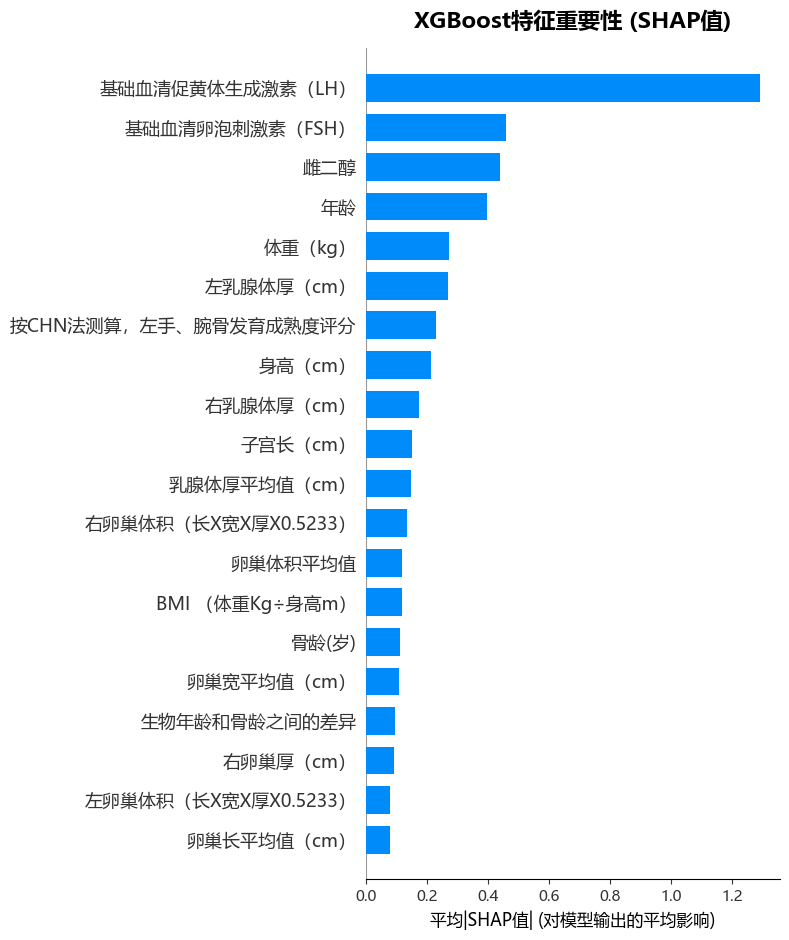

已保存: ./output/SHAP_特征重要性_条形图.pdf

2. 生成SHAP摘要散点图...


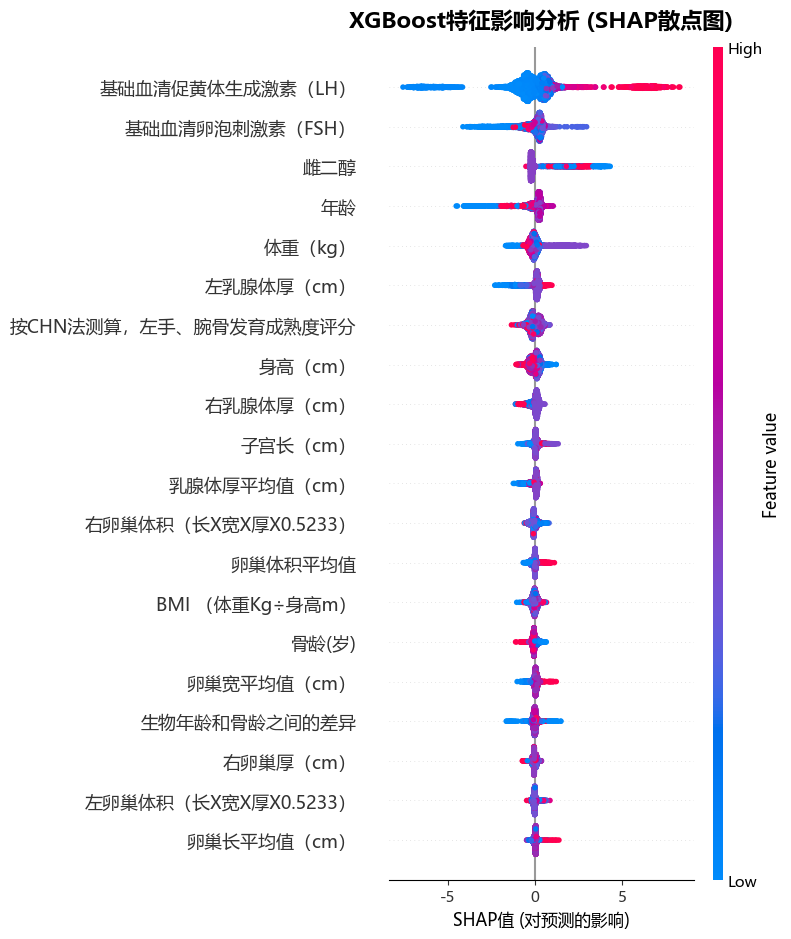

已保存: ./output/SHAP_特征影响_散点图.pdf

3. 生成单样本SHAP瀑布图（展示前3个样本）...


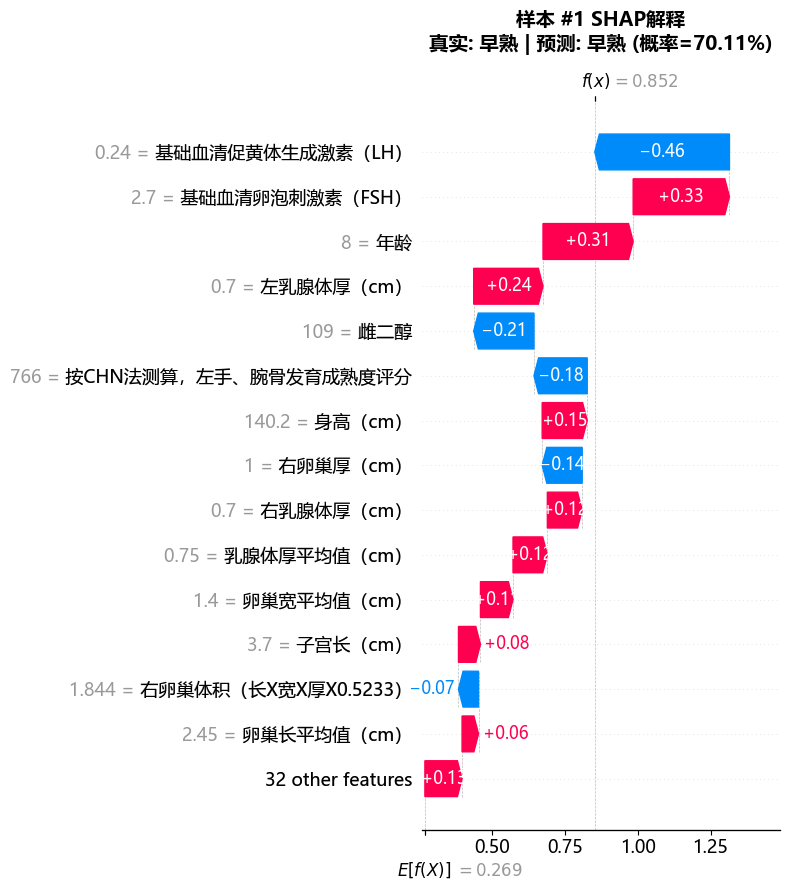

已保存: ./output/SHAP_瀑布图_样本1.pdf


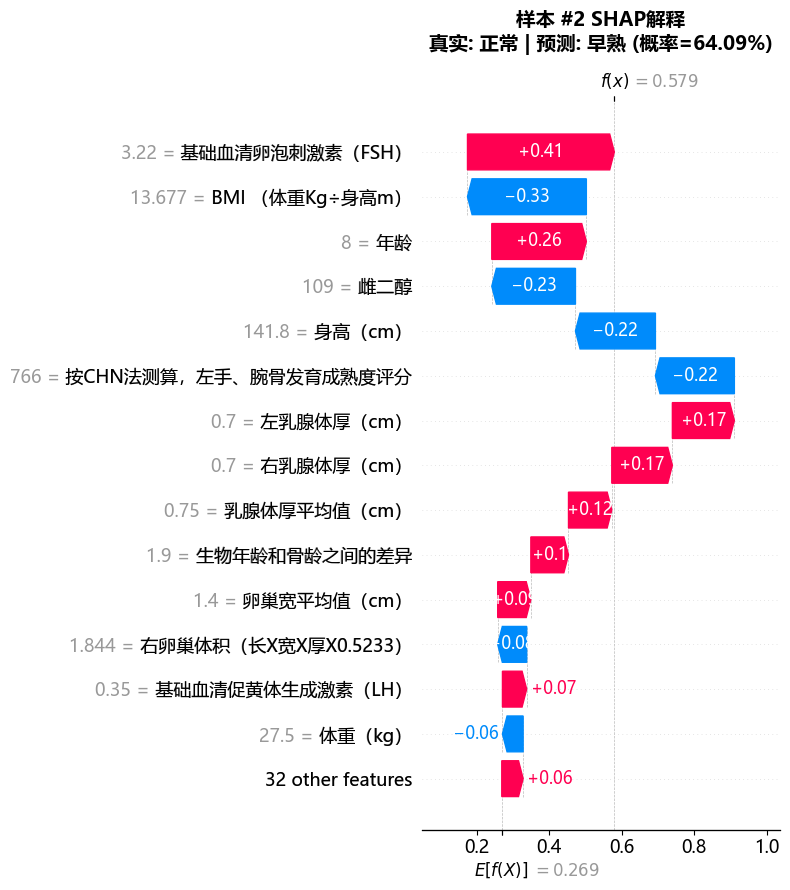

已保存: ./output/SHAP_瀑布图_样本2.pdf


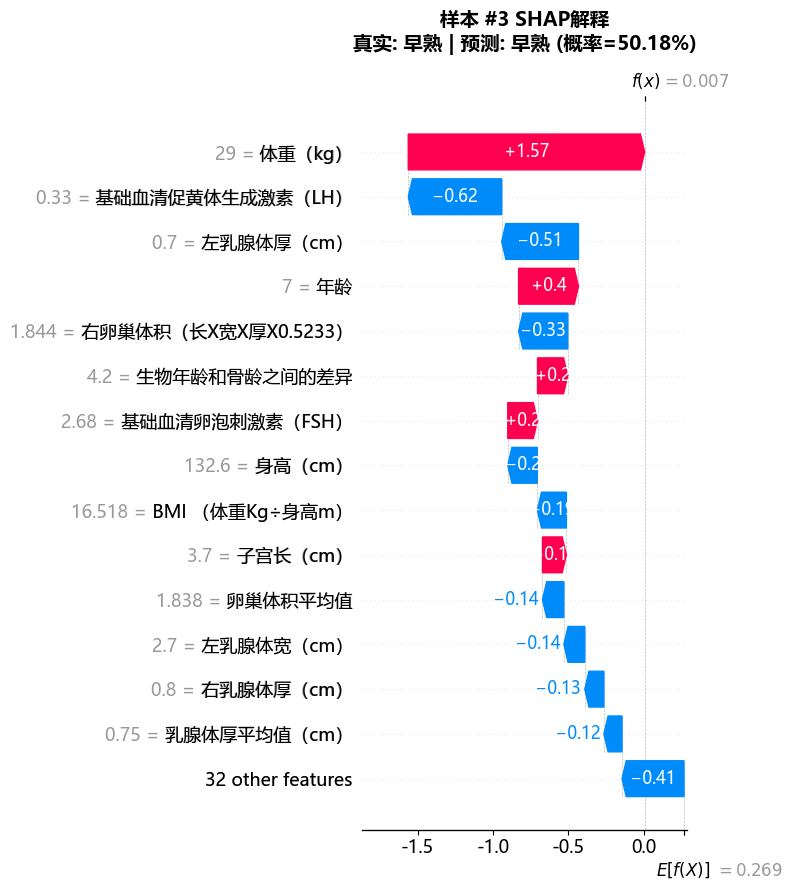

已保存: ./output/SHAP_瀑布图_样本3.pdf

4. 生成SHAP依赖图（展示Top 4重要特征）...


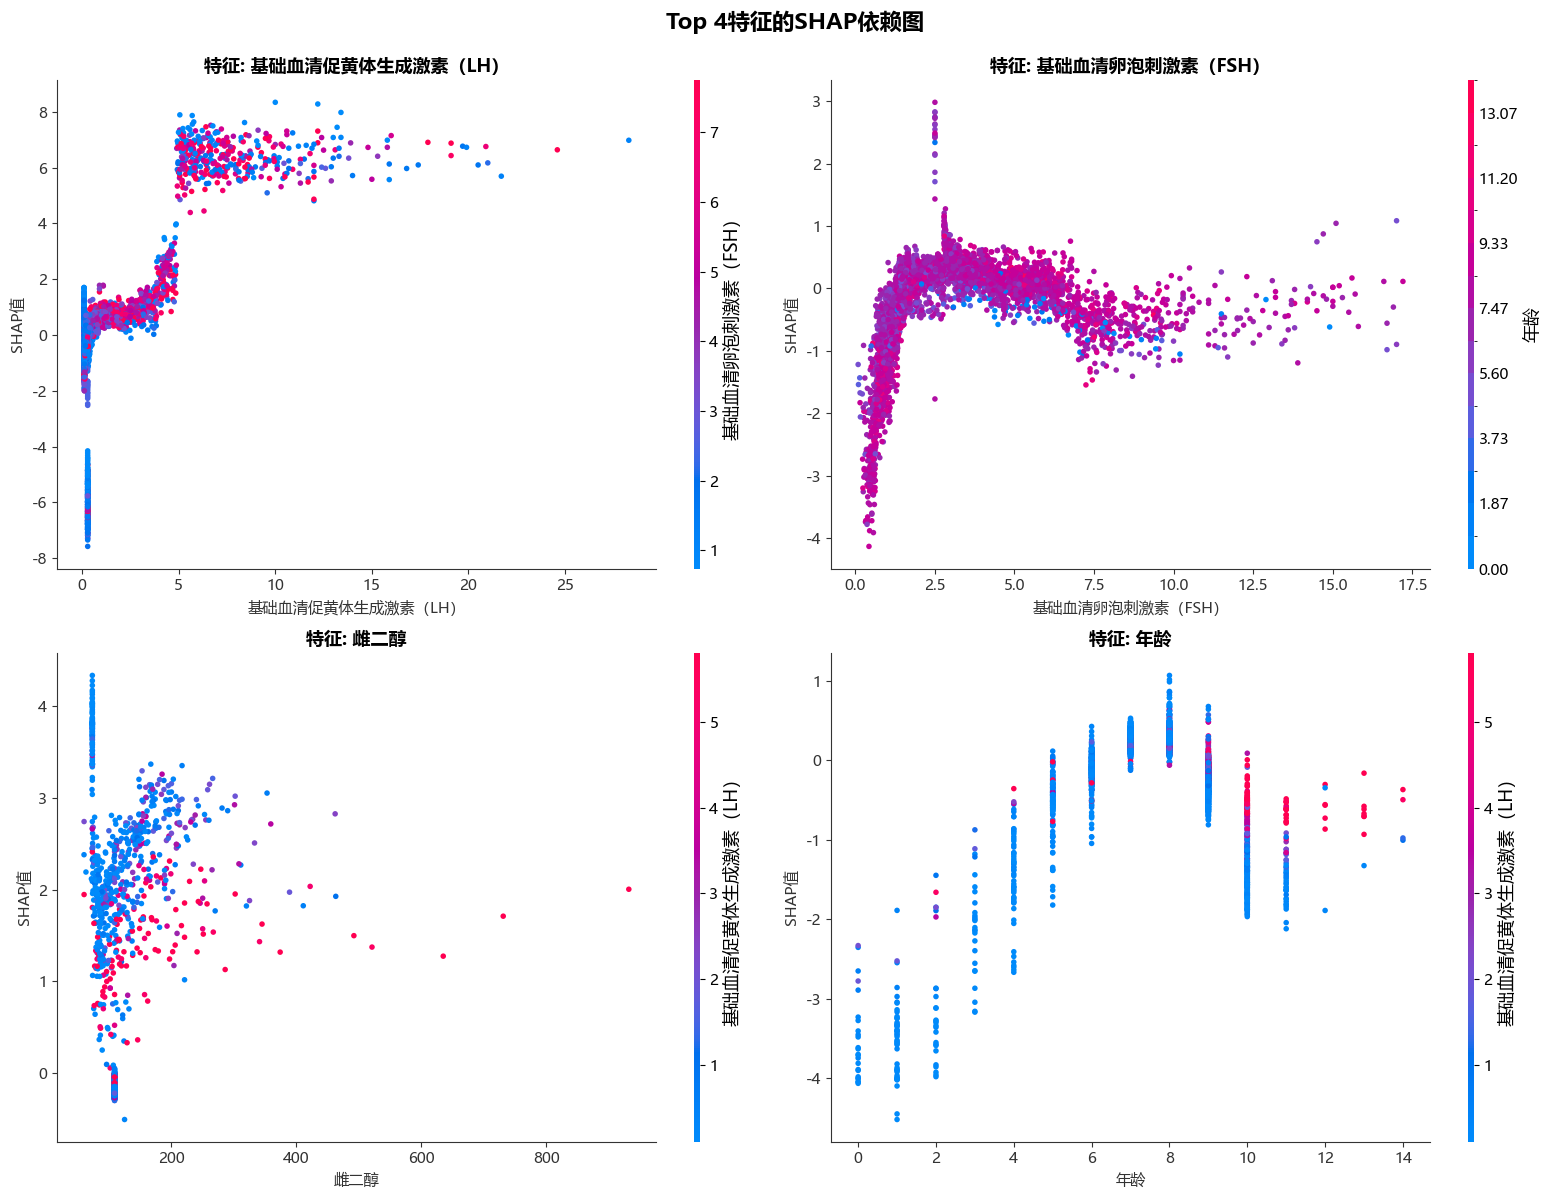

已保存: ./output/SHAP_依赖图_Top4特征.pdf

SHAP分析完成！

关键发现:
  • Top 3 最重要特征: ['基础血清促黄体生成激素（LH）', '基础血清卵泡刺激素（FSH）', '雌二醇']
  • 模型基准预测值 (expected_value): 0.2687
  • 验证集平均预测概率: 0.5633

SHAP解释含义:
  • 红色点: 特征值较高
  • 蓝色点: 特征值较低
  • 正SHAP值: 推高早熟概率
  • 负SHAP值: 降低早熟概率


In [9]:
# 创建SHAP解释器
# print("创建SHAP解释器...")
explainer = shap.TreeExplainer(xgb_model)

# 计算验证集的SHAP值（XGBoost可以直接处理缺失值）
# print("\n计算SHAP值...")
shap_values = explainer.shap_values(X_validation)

print(f"SHAP值形状: {shap_values.shape}")
print(f"验证集样本数: {X_validation.shape[0]}")
print(f"特征数: {X_validation.shape[1]}")

# 为了显示具体数值（避免nan），用中位数填充缺失值
print("\n创建填充后的数据用于可视化...")
X_validation_display = X_validation.fillna(X_validation.median())
print(f"原始缺失值: {X_validation.isnull().sum().sum()}")
print(f"填充后缺失值: {X_validation_display.isnull().sum().sum()}")
print(f"原始形状: {X_validation.shape}, 填充后形状: {X_validation_display.shape}")

# 1. SHAP特征重要性（全局）
print("\n1. 生成SHAP特征重要性条形图...")
with plt.rc_context(
    {
        "font.sans-serif": ["Arial Unicode MS", "Microsoft YaHei", "SimHei"],
        "axes.unicode_minus": False,
        "font.family": "sans-serif",
    }
):
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values,
        X_validation_display,
        feature_names=feature_cols,
        plot_type="bar",
        show=False,
        max_display=20,
    )
    plt.title("XGBoost特征重要性 (SHAP值)", fontsize=16, fontweight="bold", pad=15)
    plt.xlabel("平均|SHAP值| (对模型输出的平均影响)", fontsize=12)
    plt.tight_layout()
    plt.savefig("./output/SHAP_特征重要性_条形图.pdf", dpi=300, bbox_inches="tight")
    plt.savefig("./output/SHAP_特征重要性_条形图.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
print("已保存: ./output/SHAP_特征重要性_条形图.pdf")

# 2. SHAP摘要图（特征值分布 + SHAP影响）
print("\n2. 生成SHAP摘要散点图...")
with plt.rc_context(
    {
        "font.sans-serif": ["Arial Unicode MS", "Microsoft YaHei", "SimHei"],
        "axes.unicode_minus": False,
        "font.family": "sans-serif",
    }
):
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values,
        X_validation_display,
        feature_names=feature_cols,
        show=False,
        max_display=20,
    )
    plt.title(
        "XGBoost特征影响分析 (SHAP散点图)", fontsize=16, fontweight="bold", pad=15
    )
    plt.xlabel("SHAP值 (对预测的影响)", fontsize=12)
    plt.tight_layout()
    plt.savefig("./output/SHAP_特征影响_散点图.pdf", dpi=300, bbox_inches="tight")
    plt.savefig("./output/SHAP_特征影响_散点图.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
print("已保存: ./output/SHAP_特征影响_散点图.pdf")

# 3. 单个样本的SHAP解释（瀑布图）
print("\n3. 生成单样本SHAP瀑布图（展示前3个样本）...")
for i in range(min(3, len(X_validation))):
    with plt.rc_context(
        {
            "font.sans-serif": ["Arial Unicode MS", "Microsoft YaHei", "SimHei"],
            "axes.unicode_minus": False,
            "font.family": "sans-serif",
        }
    ):
        plt.figure(figsize=(10, 8))
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[i],
                base_values=explainer.expected_value,
                data=X_validation_display.iloc[i].values,
                feature_names=feature_cols,
            ),
            show=False,
            max_display=15,
        )

        true_label = "早熟" if y_validation_binary.iloc[i] == 1 else "正常"
        pred_label = (
            "早熟"
            if xgb_model.predict(X_validation.iloc[i : i + 1])[0] == 1
            else "正常"
        )
        pred_proba = xgb_model.predict_proba(X_validation.iloc[i : i + 1])[0][1]

        plt.title(
            f"样本 #{i+1} SHAP解释\n真实: {true_label} | 预测: {pred_label} (概率={pred_proba:.2%})",
            fontsize=14,
            fontweight="bold",
            pad=15,
        )
        plt.tight_layout()
        plt.savefig(f"./output/SHAP_瀑布图_样本{i+1}.pdf", dpi=300, bbox_inches="tight")
        plt.savefig(f"./output/SHAP_瀑布图_样本{i+1}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"已保存: ./output/SHAP_瀑布图_样本{i+1}.pdf")

# 4. SHAP依赖图（展示Top 4特征）
print("\n4. 生成SHAP依赖图（展示Top 4重要特征）...")
shap_importance = np.abs(shap_values).mean(axis=0)
top_4_features_idx = np.argsort(shap_importance)[-4:][::-1]
top_4_features = [feature_cols[i] for i in top_4_features_idx]

with plt.rc_context(
    {
        "font.sans-serif": ["Arial Unicode MS", "Microsoft YaHei", "SimHei"],
        "axes.unicode_minus": False,
        "font.family": "sans-serif",
    }
):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, feature_idx in enumerate(top_4_features_idx):
        feature_name = feature_cols[feature_idx]
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X_validation_display,
            feature_names=feature_cols,
            ax=axes[idx],
            show=False,
        )
        axes[idx].set_title(f"特征: {feature_name}", fontsize=13, fontweight="bold")
        axes[idx].set_xlabel(feature_name, fontsize=11)
        axes[idx].set_ylabel("SHAP值", fontsize=11)

    plt.suptitle("Top 4特征的SHAP依赖图", fontsize=16, fontweight="bold", y=0.995)
    plt.tight_layout()
    plt.savefig("./output/SHAP_依赖图_Top4特征.pdf", dpi=300, bbox_inches="tight")
    plt.savefig("./output/SHAP_依赖图_Top4特征.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
print("已保存: ./output/SHAP_依赖图_Top4特征.pdf")

print("\n" + "=" * 80)
print("SHAP分析完成！")
print("=" * 80)
print("\n关键发现:")
print(f"  • Top 3 最重要特征: {top_4_features[:3]}")
print(f"  • 模型基准预测值 (expected_value): {explainer.expected_value:.4f}")
print(
    f"  • 验证集平均预测概率: {xgb_model.predict_proba(X_validation)[:, 1].mean():.4f}"
)
print("\nSHAP解释含义:")
print("  • 红色点: 特征值较高")
print("  • 蓝色点: 特征值较低")
print("  • 正SHAP值: 推高早熟概率")
print("  • 负SHAP值: 降低早熟概率")

## RPART树可视化

In [ ]:
# RPART决策树可视化（使用Graphviz，支持中文）
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

output_name = f"./output/RPART决策树"

# 获取实际使用的特征名（去除全缺失列后）
# imputer会保留非全缺失的列
non_missing_features = []
for col in feature_cols:
    if not X_train[col].isna().all():
        non_missing_features.append(col)

print(f"原始特征数: {len(feature_cols)}")
print(f"实际使用特征数: {len(non_missing_features)}")
print(f"移除的全缺失特征数: {len(feature_cols) - len(non_missing_features)}")


def get_node_class(node_id, tree):
    """获取节点的多数类别 (0=正常, 1=早熟)"""
    values = tree.value[node_id][0]  # [正常样本数, 早熟样本数]
    return 1 if values[1] > values[0] else 0


def find_parent(node_id, tree):
    """找到指定节点的父节点"""
    for parent_id in range(tree.node_count):
        if (
            tree.children_left[parent_id] == node_id
            or tree.children_right[parent_id] == node_id
        ):
            return parent_id
    return None


def find_conflicting_leaves(tree):
    """找出与父节点结论不同的叶子节点"""
    conflicting_nodes = []
    for node_id in range(tree.node_count):
        is_leaf = (
            tree.children_left[node_id] == -1 and tree.children_right[node_id] == -1
        )
        if is_leaf:
            parent_id = find_parent(node_id, tree)
            if parent_id is not None:
                node_class = get_node_class(node_id, tree)
                parent_class = get_node_class(parent_id, tree)
                if node_class != parent_class:
                    conflicting_nodes.append(node_id)

    return conflicting_nodes


HIGHLIGHT_NODES = find_conflicting_leaves(rpart_model.tree_)
print(f"\n共识别出 {len(HIGHLIGHT_NODES)} 个冲突叶子节点: {HIGHLIGHT_NODES}")

dot_data = export_graphviz(
    rpart_model,
    out_file=None,
    feature_names=non_missing_features,  # 使用实际特征名
    class_names=["正常(N)", "早熟(Y)"],
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=True,
    proportion=True,
    precision=2,
    leaves_parallel=False,
    max_depth=10,
)

dot_data = dot_data.replace('fontname="helvetica"', 'fontname="SimHei"')
lines = dot_data.split("\n")
new_lines = []

for line in lines:
    for node_id in HIGHLIGHT_NODES:
        if re.match(rf"^\s*{node_id}\s+\[label=", line):
            line = line.replace(
                'fillcolor="#',
                'fillcolor="#ffcccc" color="red" penwidth=3.0 ; original_color="#',
            )
            break

    # 为边添加True/False标签
    # 匹配边的定义，例如 "0 -> 1 ;"
    edge_match = re.match(r"^(\s*)(\d+)\s*->\s*(\d+)\s*;?\s*$", line)
    if edge_match:
        indent = edge_match.group(1)
        parent = edge_match.group(2)
        child = edge_match.group(3)
        parent_int = int(parent)
        child_int = int(child)
        if parent_int < len(rpart_model.tree_.children_left):
            left_child = rpart_model.tree_.children_left[parent_int]
            right_child = rpart_model.tree_.children_right[parent_int]

            if child_int == left_child:
                # 左分支 = True
                line = f'{indent}{parent} -> {child} [label="True", fontsize=12, fontname="SimHei"] ;'
            elif child_int == right_child:
                # 右分支 = False
                line = f'{indent}{parent} -> {child} [label="False", fontsize=12, fontname="SimHei"] ;'

    new_lines.append(line)

dot_data = "\n".join(new_lines)

graph = graphviz.Source(dot_data, encoding="utf-8")
graph.format = "pdf"
pdf_path = graph.render(output_name, cleanup=True)
graph.format = "png"
png_path = graph.render(output_name, cleanup=True)

print(f"\nRPART决策树已保存")
print(f"模型实际深度: {rpart_model.get_depth()}")
print(f"叶节点数: {rpart_model.get_n_leaves()}")
print(f"总节点数: {rpart_model.tree_.node_count}")
print(f"冲突叶子节点数: {len(HIGHLIGHT_NODES)}")
print(f"AUC: {auc_rpart:.4f}, F1: {f1_rpart:.4f}")
print(f"{output_name}.pdf")
print(f"{output_name}.png")
graph